In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import pickle as pkl
import os
from glob import glob
from paulinggrl2022.model import Model
from paulinggrl2022.cesm_functions import fixmonth, globalmean
from scipy.stats import linregress

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 10

In [9]:
models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "GISS-E2-1-G",
    "GISS-E2-1-H",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "MIROC-ES2L",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0",
    "NorCPM1",
    "UKESM1-0-LL"
]

experiments = ["historical", "abrupt-4xCO2"]

### A LOT of CMIP6 data is needed for this calculation.

I have just serialized out the result needed, but if you want to do it yourself, the CMIP6 data is available at https://esgf-node.llnl.gov/projects/cmip6/

The utility here: https://github.com/tloureiro/cmip6_downloader is useful for getting the CMIP6 data more quickly than manually from the website

### Compute the Warm Pool Index as defined in G&uuml;nther et al. (2022)

#### I've left the function I used here for reference, but I serialized out the WPI to save downloading all the data again

In [20]:
def compute_warm_pool(da):
    # Computes the warm pool region temperature as defined in Gunther et al. (2022)
    tmp = da.sel(lat=slice(-30, 30), lon=slice(50, 200))
    return tmp.weighted(np.cos(np.deg2rad(tmp.lat))).mean(("lat", "lon"))

In [21]:
if os.path.isfile("wpi_data.pkl"):
    with open("wpi_data.pkl", "rb") as f:
        wpi = pkl.load(f)
else:
    wpi = {}
    for name in models:
        wpi[name] = {}
        for exp in experiments:
            if exp == "historical":
                g = gmst[name][exp].sel(year=slice(1991, 1993))
                w = warmpool[name][exp].sel(year=slice(1991, 1993))
            else:
                g = gmst[name][exp].isel(year=slice(0, 150))
                w = warmpool[name][exp].isel(year=slice(0, 150))

            slope, intcpt, r, p, stderr = linregress(g.data, w.data)
            print(f"{name}: {slope:5.3f}")

            wpi[name][exp] = slope

In [22]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test
    
ecs_dict["CESM2-LENS"] = ecs_dict["CESM2"]

ACCESS-ESM1-5 = 3.8839034758064814
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253567
MIROC-ES2L = 2.6605264351565174
MIROC6 = 2.601790969650521
MPI-ESM1-2-HR = 2.9797516932086876
MPI-ESM1-2-LR = 3.0254401947450527
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.0317257208870005
UKESM1-0-LL = 5.359162439690016


### Compute correlation between $\Delta$WPI and ECS

In [23]:
delta_wpi = np.array([wpi[name]["historical"] - wpi[name]["abrupt-4xCO2"] for name in models])
ecs = np.array([ecs_dict[name] for name in models])

slope, intcpt, r, p, stderr = linregress(ecs, delta_wpi)
print(f"Slope= {slope:5.3f}")
print(f"r = {r:5.3f}")
print(f"p = {p:5.3f}")

Slope= 0.004
r = 0.025
p = 0.927


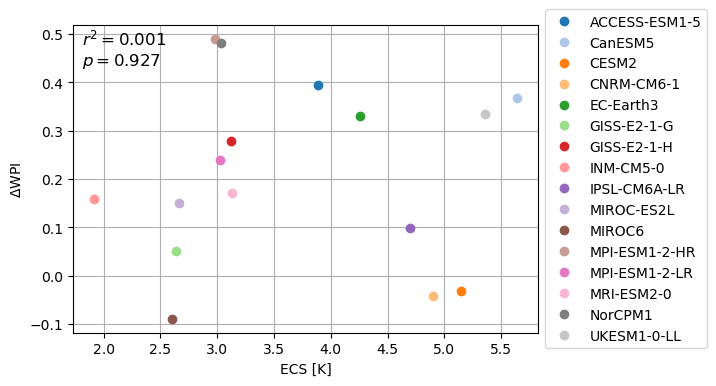

In [24]:
colors = pl.cm.tab20.colors

fig = plt.figure(1)
for n, name in enumerate(models):
    delta_wpi = wpi[name]["historical"] - wpi[name]["abrupt-4xCO2"]
    plt.plot(ecs_dict[name], delta_wpi, "o", label=name, color=colors[n])
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.xlabel("ECS [K]")
plt.ylabel("$\Delta$WPI")

plt.annotate(
    f"$r^2=${r**2:5.3f}\n$p=${p:5.3f}",
    xy=(0.02, 0.87),
    xycoords="axes fraction",
    fontsize=12
)

fig.savefig("../figures/deltawpi_150yr_vs_ecs.png",
            bbox_inches="tight", dpi=300)